Loading data...

Dataset shape: (372, 4)

First few rows:
                      NAME        INSTITUTE  \
0      Ashutosh Srivastava  IIT GANDHINAGAR   
1            Bhaskar Datta  IIT GANDHINAGAR   
2            Dhiraj Bhatia  IIT GANDHINAGAR   
3  Karla P. MercadoShekhar  IIT GANDHINAGAR   
4            Mukesh Dhanka  IIT GANDHINAGAR   

                                               PHD  \
0   CSIR Centre for Cellular and Molecular Biology   
1                       Carnegie Mellon University   
2                                      TIFR Mumbai   
3                       (University of Pittsburgh)   
4                                       IIT Bombay   

                                             POSTDOC  
0                                  Nagoya University  
1                    Georgia Institute of Technology  
2                                    Institute Curie  
3  University of Cincinnati College of Medicine (...  
4          DBT inStem, Bangalore (Mar 2021 May 2022)  

Mis

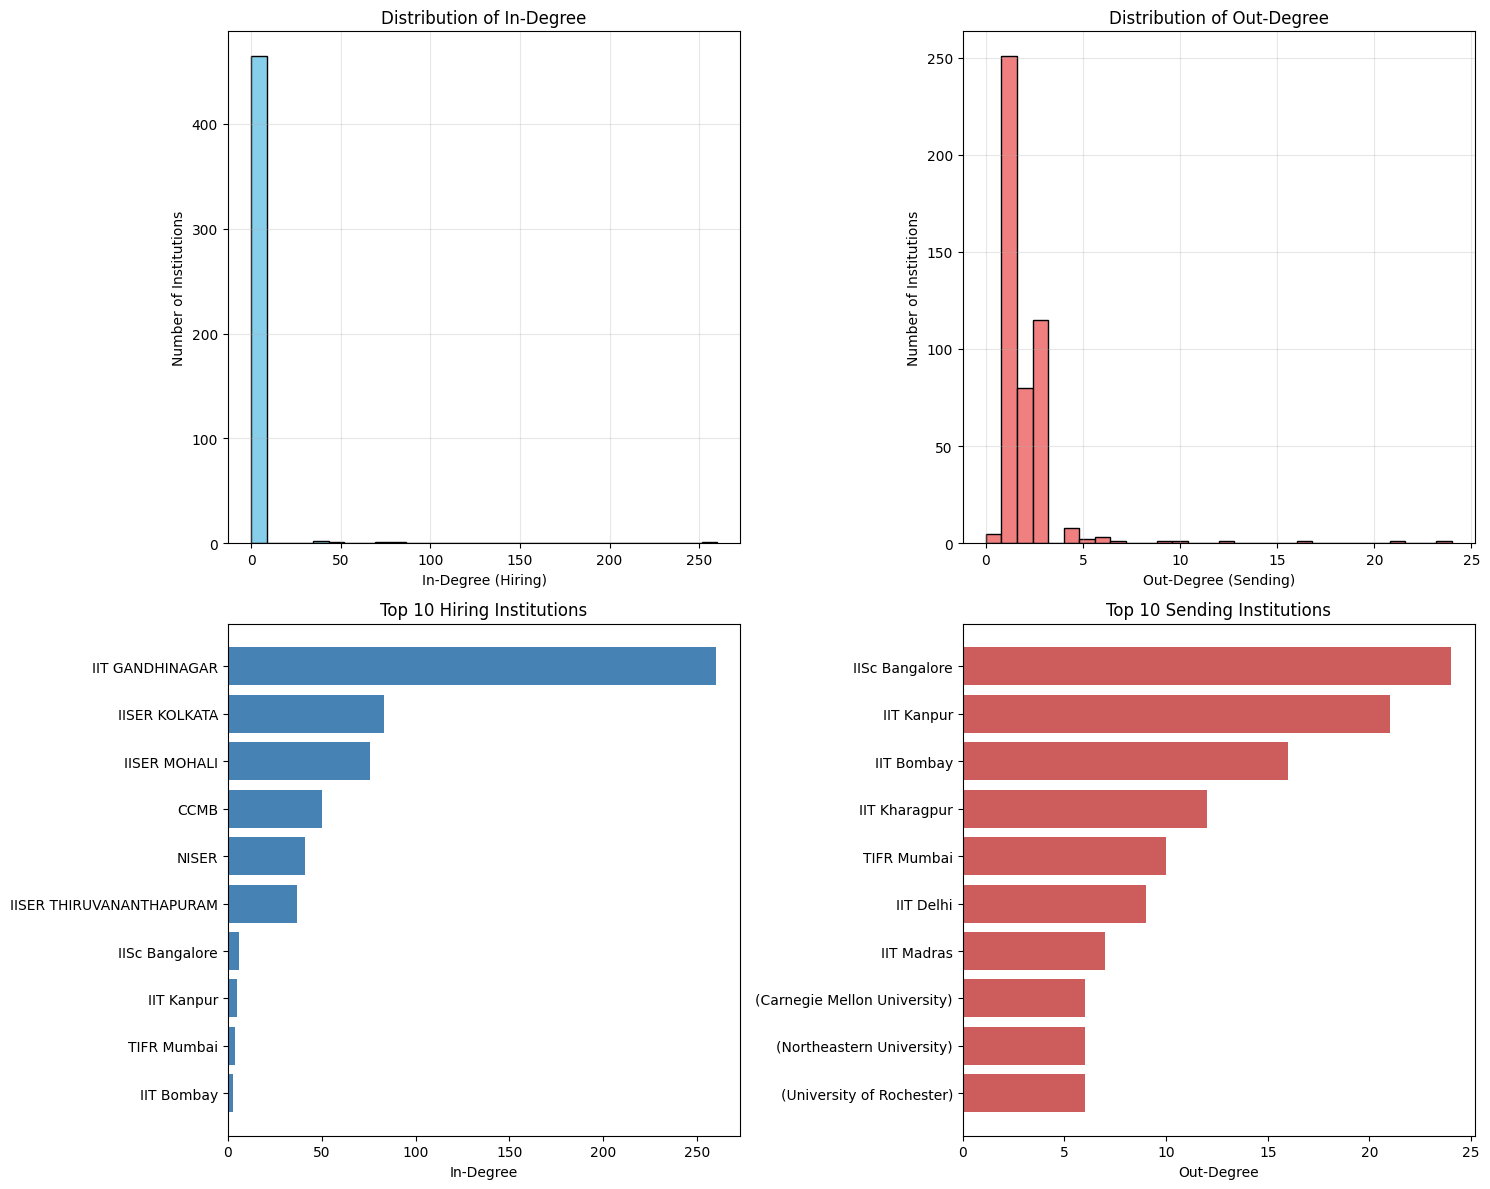

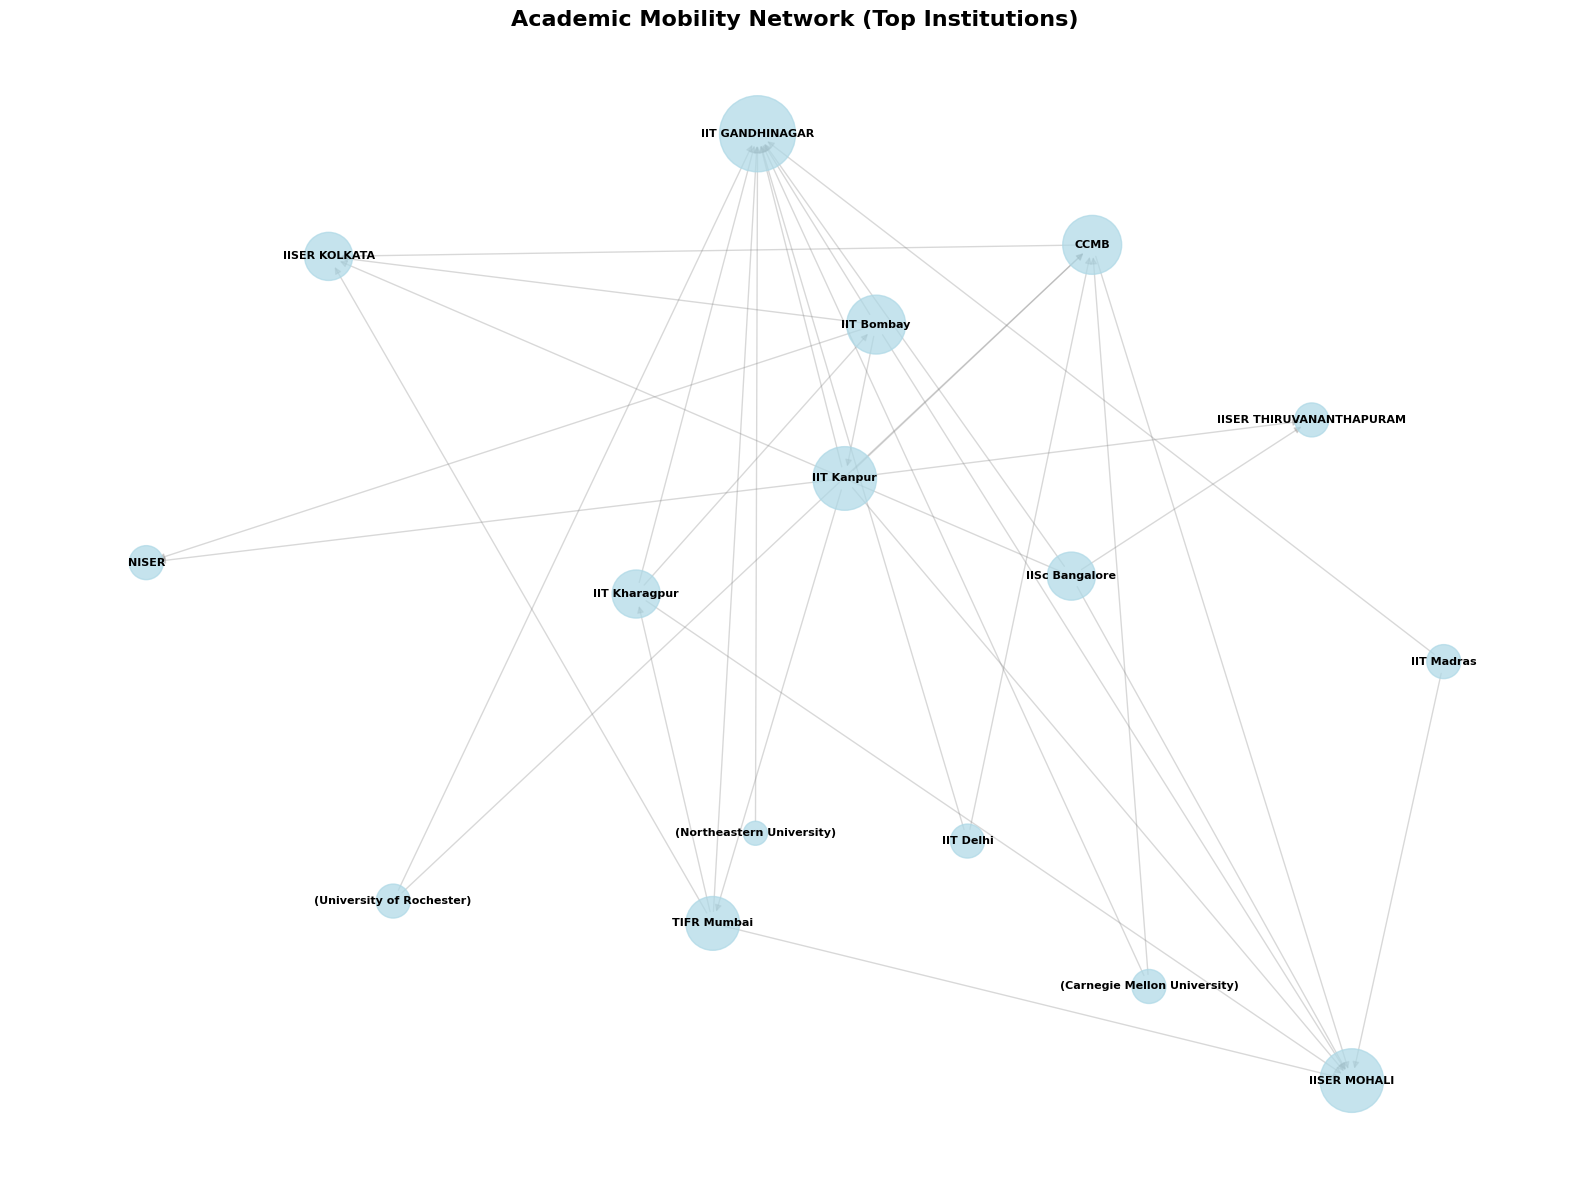

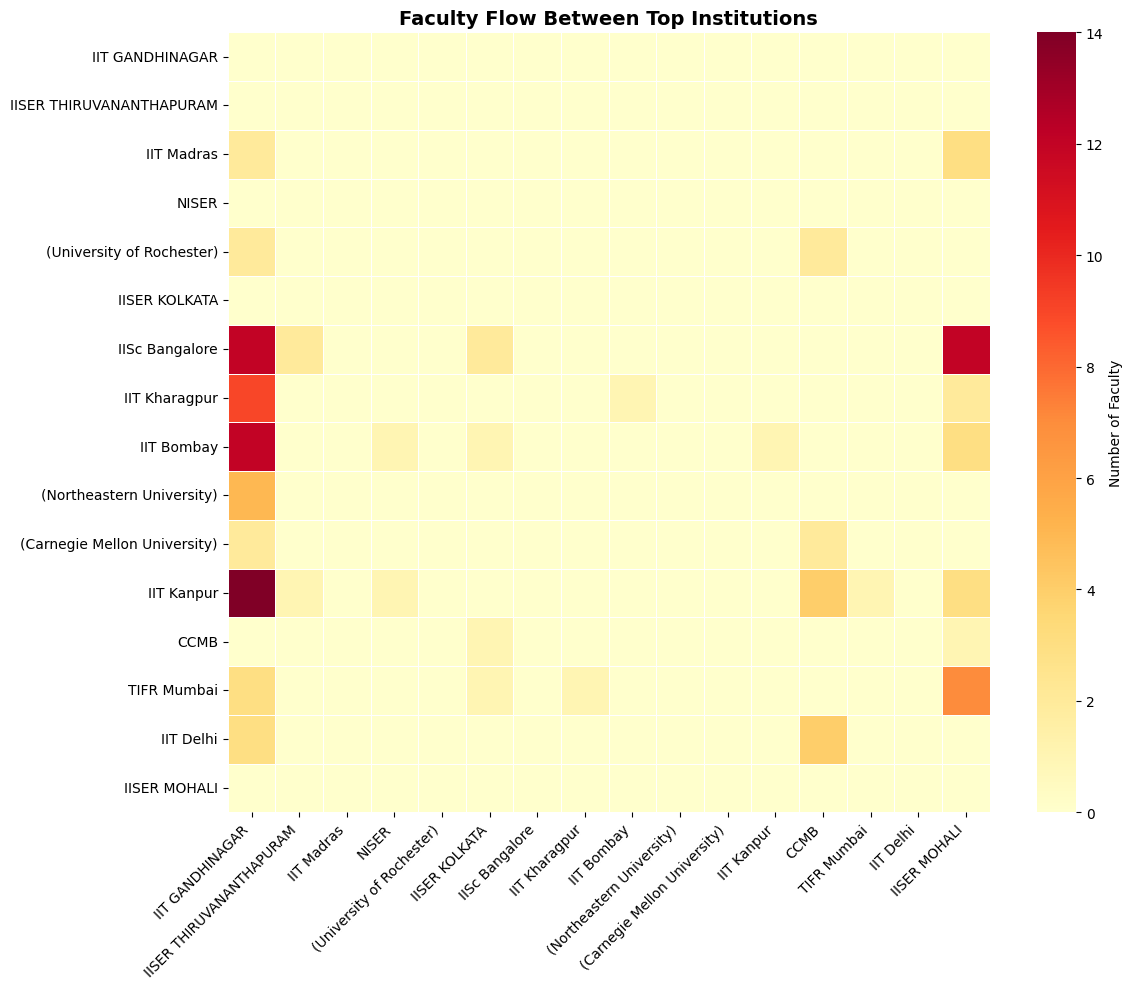

In [14]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')


print("Loading data...")
file_path = "/content/drive/MyDrive/Colab Notebooks/NET.csv"
df = pd.read_csv(file_path, encoding='latin-1')


print(f"\nDataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nMissing values:")
print(df.isnull().sum())


print("\n" + "="*50)
print("DATA CLEANING")
print("="*50)


df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)


df['has_phd'] = df['PHD'].notna() & (df['PHD'] != '') & (df['PHD'].str.lower() != 'nan')
df['has_postdoc'] = df['POSTDOC'].notna() & (df['POSTDOC'] != '') & (df['POSTDOC'].str.lower() != 'nan')
df['has_institute'] = df['INSTITUTE'].notna() & (df['INSTITUTE'] != '') & (df['INSTITUTE'].str.lower() != 'nan')

print(f"Records with PhD info: {df['has_phd'].sum()}")
print(f"Records with Postdoc info: {df['has_postdoc'].sum()}")
print(f"Records with Institute info: {df['has_institute'].sum()}")


print("\n" + "="*50)
print("BUILDING NETWORK GRAPH")
print("="*50)

G = nx.DiGraph()


edge_list = []


for idx, row in df.iterrows():
    if row['has_phd'] and row['has_institute']:
        phd = row['PHD']
        institute = row['INSTITUTE']
        if phd != institute:  # Avoid self-loops for now
            edge_list.append((phd, institute, 'phd_to_faculty'))


for idx, row in df.iterrows():
    if row['has_phd'] and row['has_postdoc']:
        phd = row['PHD']
        postdoc = row['POSTDOC']
        if phd != postdoc:
            edge_list.append((phd, postdoc, 'phd_to_postdoc'))

for idx, row in df.iterrows():
    if row['has_postdoc'] and row['has_institute']:
        postdoc = row['POSTDOC']
        institute = row['INSTITUTE']
        if postdoc != institute:
            edge_list.append((postdoc, institute, 'postdoc_to_faculty'))


edge_counter = Counter([(e[0], e[1]) for e in edge_list])
for (source, target), weight in edge_counter.items():
    G.add_edge(source, target, weight=weight)

print(f"Number of nodes (institutions): {G.number_of_nodes()}")
print(f"Number of edges (connections): {G.number_of_edges()}")


print("\n" + "="*50)
print("NETWORK METRICS")
print("="*50)

in_degree = dict(G.in_degree())
out_degree = dict(G.out_degree())

print("\n--- TOP 10 INSTITUTIONS BY IN-DEGREE (Hiring Faculty) ---")
top_in = sorted(in_degree.items(), key=lambda x: x[1], reverse=True)[:10]
for inst, degree in top_in:
    print(f"{inst}: {degree} incoming connections")

print("\n--- TOP 10 INSTITUTIONS BY OUT-DEGREE (Sending Faculty) ---")
top_out = sorted(out_degree.items(), key=lambda x: x[1], reverse=True)[:10]
for inst, degree in top_out:
    print(f"{inst}: {degree} outgoing connections")

print("\n--- TOP 10 INSTITUTIONS BY PAGERANK (Overall Influence) ---")
pagerank = nx.pagerank(G)
top_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:10]
for inst, score in top_pagerank:
    print(f"{inst}: {score:.4f}")


print("\n--- TOP 10 INSTITUTIONS BY BETWEENNESS (Bridge Institutions) ---")
betweenness = nx.betweenness_centrality(G)
top_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:10]
for inst, score in top_betweenness:
    print(f"{inst}: {score:.4f}")


print("\n" + "="*50)
print("ACADEMIC INBREEDING ANALYSIS")
print("="*50)

inbreeding_count = 0
inbreeding_list = []

for idx, row in df.iterrows():
    if row['has_phd'] and row['has_institute']:
        if row['PHD'] == row['INSTITUTE']:
            inbreeding_count += 1
            inbreeding_list.append(row['INSTITUTE'])

print(f"Total faculty hired from their own PhD institution: {inbreeding_count}")
if inbreeding_count > 0:
    print("\nInstitutions with most self-hiring:")
    inbreeding_counter = Counter(inbreeding_list)
    for inst, count in inbreeding_counter.most_common(10):
        print(f"{inst}: {count} cases")


print("\n" + "="*50)
print("CAREER PATH ANALYSIS")
print("="*50)

complete_paths = df[df['has_phd'] & df['has_postdoc'] & df['has_institute']].copy()
print(f"Faculty with complete path (PhD -> Postdoc -> Faculty): {len(complete_paths)}")

direct_paths = df[df['has_phd'] & ~df['has_postdoc'] & df['has_institute']].copy()
print(f"Faculty with direct path (PhD -> Faculty, no postdoc): {len(direct_paths)}")


if len(complete_paths) > 0:
    print("\n--- TOP 10 COMPLETE CAREER PATHS ---")
    complete_paths['path'] = complete_paths['PHD'] + ' -> ' + complete_paths['POSTDOC'] + ' -> ' + complete_paths['INSTITUTE']
    path_counts = complete_paths['path'].value_counts().head(10)
    for path, count in path_counts.items():
        print(f"{path}: {count} faculty")


print("\n" + "="*50)
print("GENERATING VISUALIZATIONS")
print("="*50)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].hist(list(in_degree.values()), bins=30, color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel('In-Degree (Hiring)')
axes[0, 0].set_ylabel('Number of Institutions')
axes[0, 0].set_title('Distribution of In-Degree')
axes[0, 0].grid(alpha=0.3)

axes[0, 1].hist(list(out_degree.values()), bins=30, color='lightcoral', edgecolor='black')
axes[0, 1].set_xlabel('Out-Degree (Sending)')
axes[0, 1].set_ylabel('Number of Institutions')
axes[0, 1].set_title('Distribution of Out-Degree')
axes[0, 1].grid(alpha=0.3)

top_in_names = [x[0] for x in top_in]
top_in_values = [x[1] for x in top_in]
axes[1, 0].barh(top_in_names, top_in_values, color='steelblue')
axes[1, 0].set_xlabel('In-Degree')
axes[1, 0].set_title('Top 10 Hiring Institutions')
axes[1, 0].invert_yaxis()

top_out_names = [x[0] for x in top_out]
top_out_values = [x[1] for x in top_out]
axes[1, 1].barh(top_out_names, top_out_values, color='indianred')
axes[1, 1].set_xlabel('Out-Degree')
axes[1, 1].set_title('Top 10 Sending Institutions')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.savefig('network_analysis_metrics.png', dpi=300, bbox_inches='tight')
print("Saved: network_analysis_metrics.png")

fig, ax = plt.subplots(figsize=(16, 12))

# Create subgraph with top institutions
top_institutions = set([x[0] for x in top_in[:15]] + [x[0] for x in top_out[:15]])
subgraph = G.subgraph(top_institutions)

# Layout
pos = nx.spring_layout(subgraph, k=2, iterations=50, seed=42)


node_sizes = [300 * (subgraph.in_degree(node) + subgraph.out_degree(node)) for node in subgraph.nodes()]

nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes,
                       node_color='lightblue', alpha=0.7, ax=ax)
nx.draw_networkx_labels(subgraph, pos, font_size=8, font_weight='bold', ax=ax)
nx.draw_networkx_edges(subgraph, pos, alpha=0.3, arrows=True,
                       arrowsize=10, edge_color='gray', ax=ax)

ax.set_title('Academic Mobility Network (Top Institutions)', fontsize=16, fontweight='bold')
ax.axis('off')
plt.tight_layout()
plt.savefig('network_visualization.png', dpi=300, bbox_inches='tight')
print("Saved: network_visualization.png")


fig, ax = plt.subplots(figsize=(12, 10))

top_20 = list(set([x[0] for x in top_in[:20]] + [x[0] for x in top_out[:20]]))
matrix = pd.DataFrame(0, index=top_20, columns=top_20)

for source, target, data in G.edges(data=True):
    if source in top_20 and target in top_20:
        matrix.loc[source, target] = data['weight']

sns.heatmap(matrix, annot=False, cmap='YlOrRd', linewidths=0.5,
            cbar_kws={'label': 'Number of Faculty'}, ax=ax)
ax.set_title('Faculty Flow Between Top Institutions', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('institution_heatmap.png', dpi=300, bbox_inches='tight')
print("Saved: institution_heatmap.png")

print("\n" + "="*50)
print("ANALYSIS COMPLETE!")
print("="*50)
print("\nGenerated files:")
print("1. network_analysis_metrics.png - Degree distributions and top institutions")
print("2. network_visualization.png - Network graph of top institutions")
print("3. institution_heatmap.png - Heatmap of faculty flows")

print("\nSaving processed data...")
network_stats = pd.DataFrame({
    'Institution': list(G.nodes()),
    'In_Degree': [in_degree[node] for node in G.nodes()],
    'Out_Degree': [out_degree[node] for node in G.nodes()],
    'PageRank': [pagerank[node] for node in G.nodes()],
    'Betweenness': [betweenness[node] for node in G.nodes()]
})
network_stats = network_stats.sort_values('PageRank', ascending=False)
network_stats.to_csv('institution_network_stats.csv', index=False)
print("Saved: institution_network_stats.csv")

print("\n✓ All done! Check the generated files for insights.")

In [8]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls "/content/drive/MyDrive/Colab Notebooks"


 ccmb.ipynb				        IIT_HYD_FINAL.csv
'Copy of Assignment_4.ipynb'		        IIT_PHD.csv
'Copy of Copy of Assignment_1 (1).ipynb'        IIT_PHD.gsheet
'Copy of Copy of Assignment_1.ipynb'	        merged_faculty_salary.csv
'Copy of Copy of Assignment_2.ipynb'	        name_matching_report.csv
'Copy of Copy of Assignment_4.ipynb'	        NAMES.csv
'Copy of Hazil Harris - Assignment_6.ipynb'     NET.csv
'Copy of Hazil Harris - Exam_Session_6.ipynb'   NOMR_SAL.csv
 count.csv				        prediction_ML.ipynb
 DATACOMBINED_V1.csv			        Sanky_Fig.ipynb
 DS_project.ipynb			       'solutions of midsem.ipynb'
 Facultysalary.csv			        TEST.csv
 FINAL.csv				        TEST-IISERK.csv
 geocoded_phd_institutions.csv		        TEST_IISERM.csv
 Get_citations.ipynb			        Untitled
'Hazil Harris ms23182'			        Untitled0.ipynb
'Hazilms23182 (assignment.2)'		        Untitled1.ipynb


In [59]:
!pip install pandas networkx matplotlib seaborn

!python script_name.py

python3: can't open file '/content/script_name.py': [Errno 2] No such file or directory


In [6]:
!pip install pandas matplotlib seaborn numpy

In [31]:
!ls content/drive/MyDrive/Colab

ls: cannot access 'content/drive/MyDrive/Colab': No such file or directory


In [62]:
!pip install pandas matplotlib seaborn numpy

!python inbreeding_analysis.py

python3: can't open file '/content/inbreeding_analysis.py': [Errno 2] No such file or directory
